In [1]:
import numpy as np
import scipy.io as sio
import ase
from ase.io import read
from lib import ase_view, traj_view
import matplotlib.pyplot as plt
from ipywidgets import *
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
%matplotlib notebook

# Fonction Affines

Une fonction affine est une fonction de la forme:
\begin{align}
f(x)=ax+b
\end{align}

Supposons que nous étudions une propriété physique $y$ qui dépend linéairement d'une autre propriété $x$.

La fonction ci-dessous génére un nombre alétaire $a\in [low;high]$

In [2]:
def rand_in(low,high):
    return (high-low)*np.random.random()+low

Définir un vecteur $x$ contenant une dizaine de valeurs aléatoire dans l'interval $[0;1]$, une fonction affine avec $b=0$ et $a \in [1;5]$ généré aléatoirement.
Calculer $y=f(x)$ et tracer les points (x,y) avec la fonction plt.scatter. 

<IPython.core.display.Javascript object>


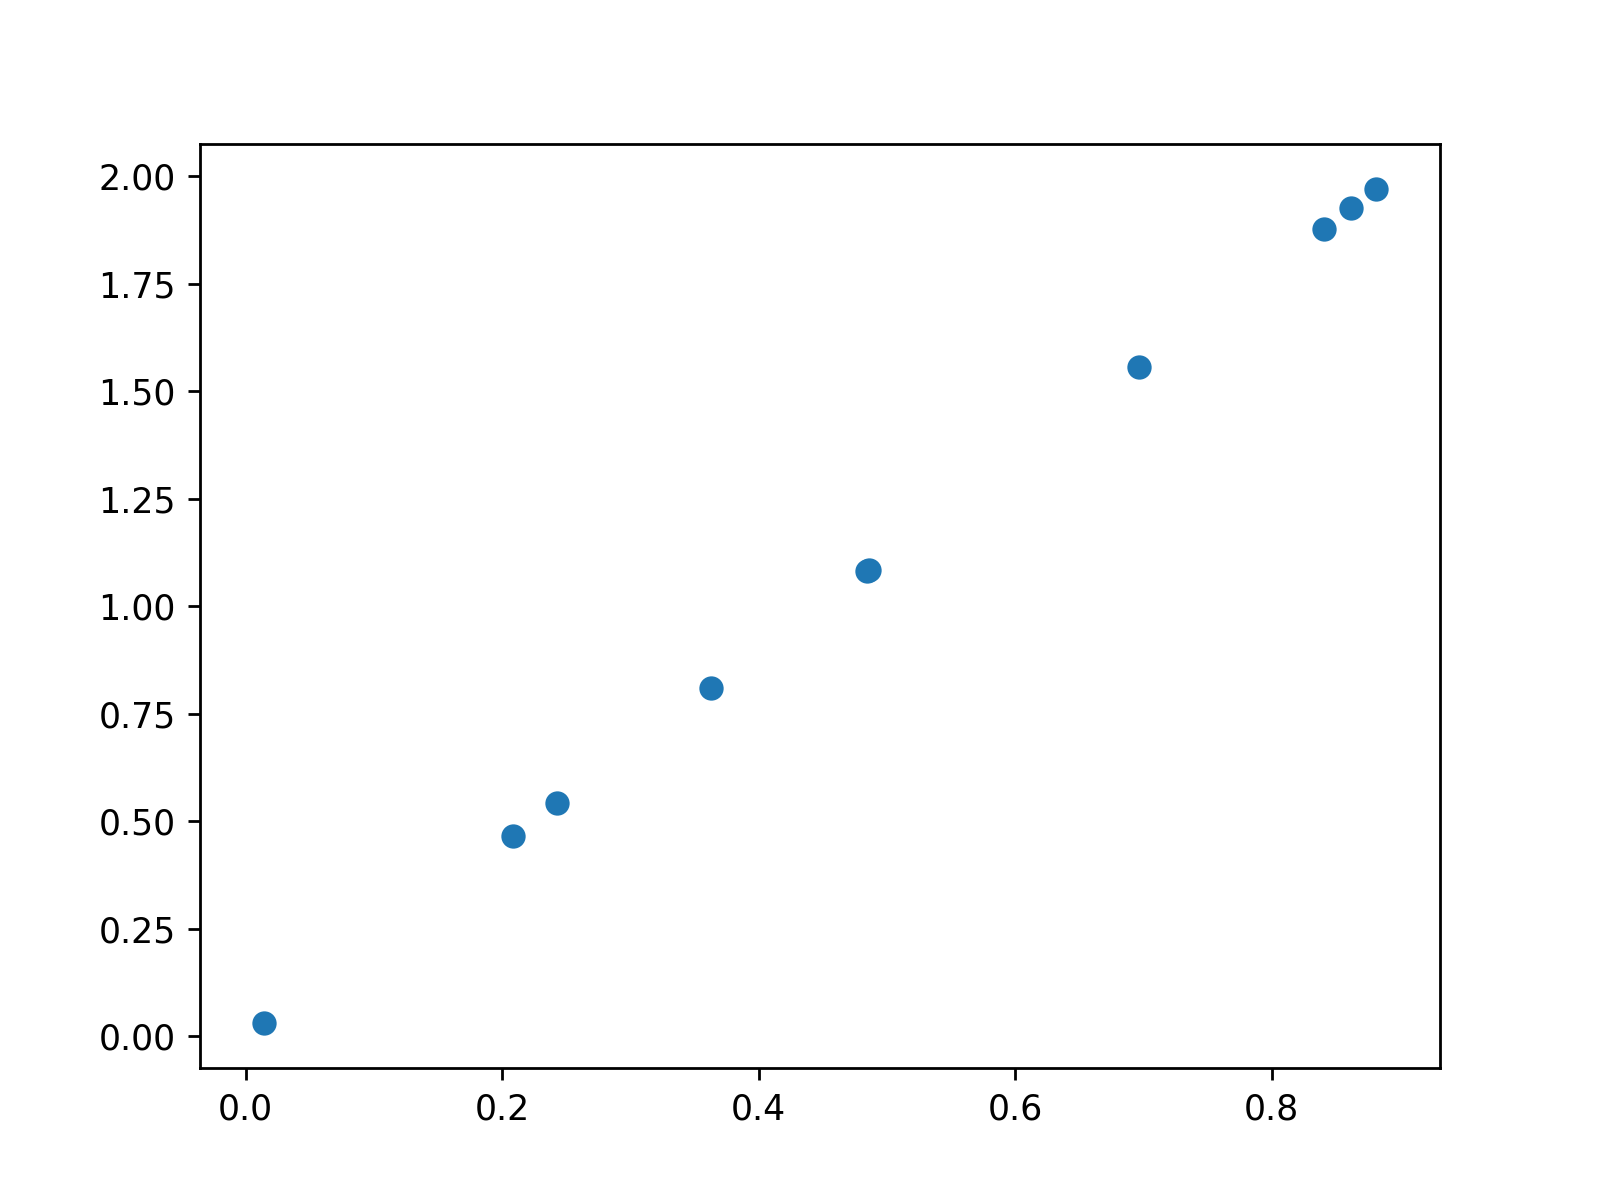

In [6]:
a=rand_in(5,1)
x=np.random.random(10)
y=a*x
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y)
plt.show()

Retrouver la valeur de $a$ à partir des valeurs de $x$ et $y$ (sans faire "print(a)"!!).
Pour vérifier, tracer la ligne représentant la fonction affine $f(x)=ax$ avec plt.plot, en plus des points (x,y).

<IPython.core.display.Javascript object>


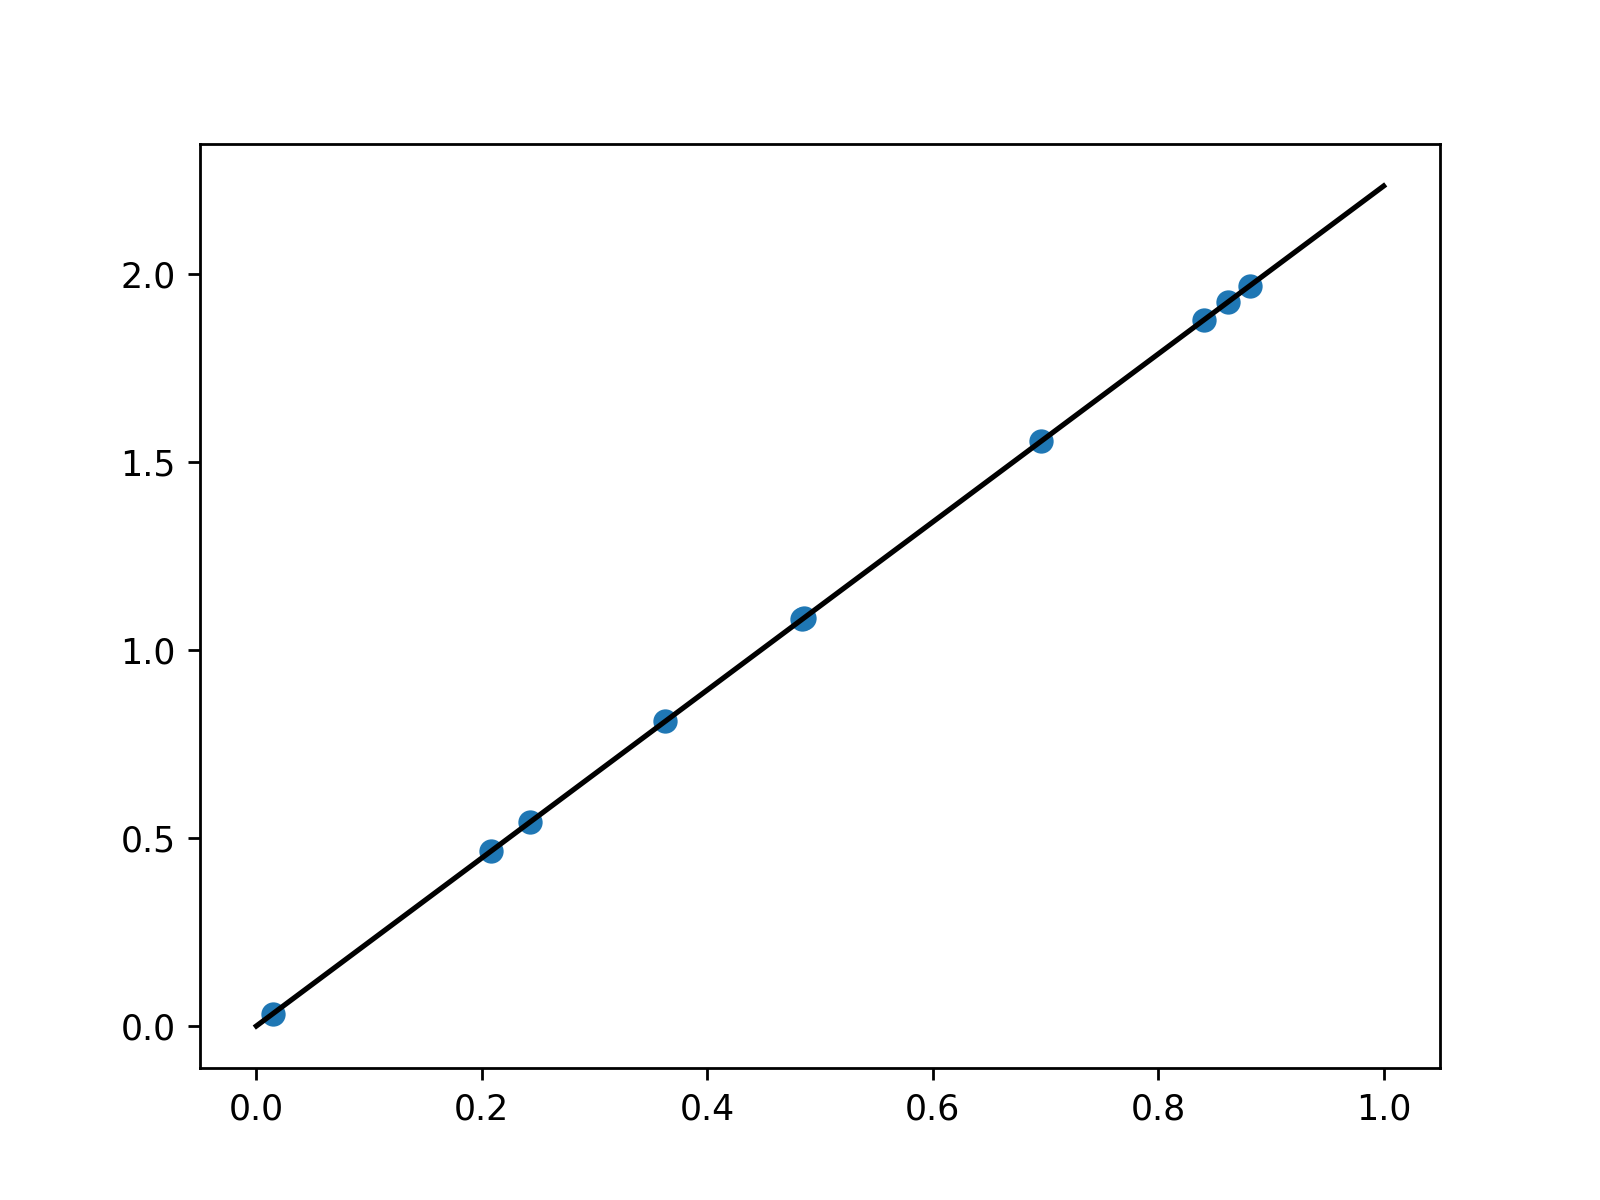

In [7]:
pente=(y[0]/x[0])
xx=np.linspace(0,1,10)
yy=pente*xx
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(xx,yy, color='k')
ax.scatter(x,y)
plt.show()

# Régression linéaire

En pratique, les choses ne collent pas aussi bien... $f$ ne représente pas parfaitement la réalité, c'est un modèle. D'autres facteurs peuvent affecter les valeurs de $y$. 

Ajouter artifiellement du bruit aux données: 
Génerer une autre pente $a$, des points x aléatoires, et des valeurs
$y=ax+s$ ou s est un nombre aléatoire généré grace à une distribution normale centrée en $0$ et de variance $0.2$ (différent pour chaque valeur de x).

<IPython.core.display.Javascript object>


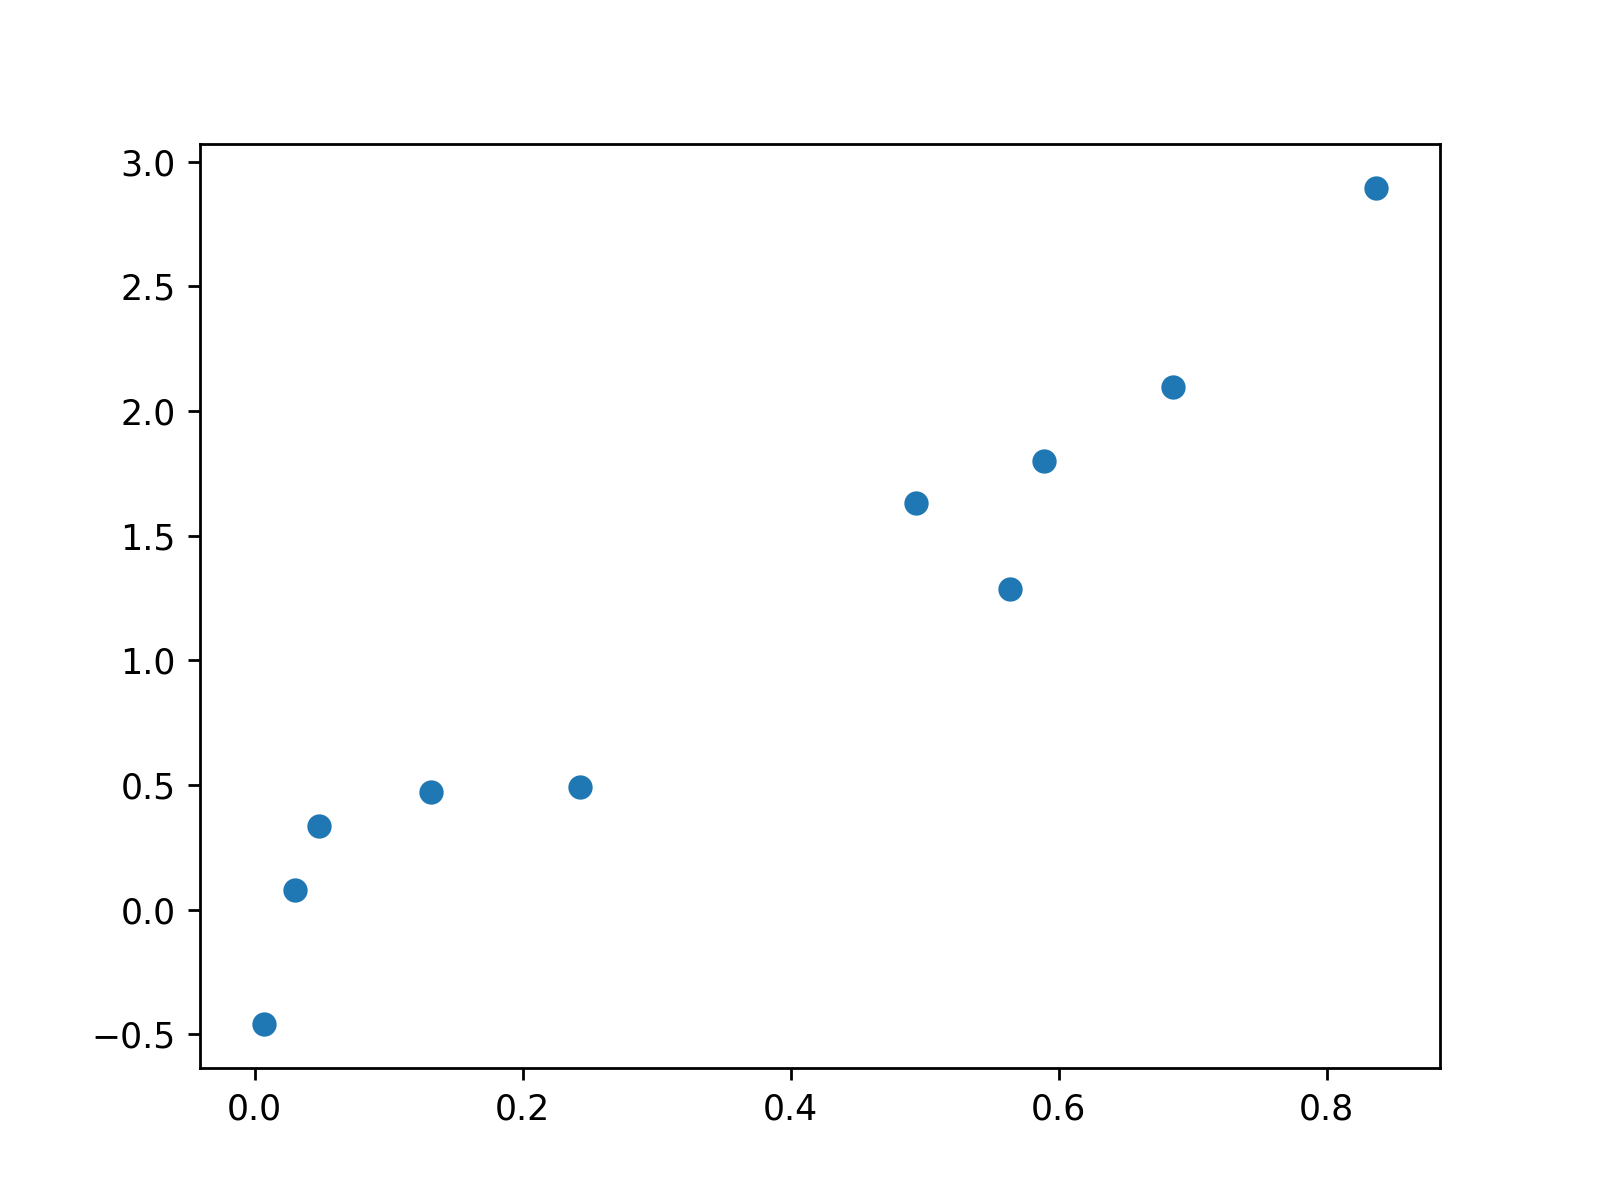

In [8]:
a=rand_in(1,5)
x=np.random.random(10)
y=a*x+np.array([np.random.normal(scale=0.2) for i in range(len(x))])
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y)
plt.show()

La cellule ci-dessous trace une fonction affine dont la pente est un nombre entier $a$ réglable. Faire glisser la barre ci-dessous pour changer la pente de la droite tracée et estimer la nouvelle valeur de $a$.

In [9]:
## here they can use the slider to change the slope of the line until it fits the points best
@interact(a=2)
def plot_line(a):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.scatter(x,y)
    xx=np.linspace(0,1,3)
    ax.plot(xx,a*xx)
    plt.show()
    return

A Jupyter Widget

"Estimer la valeur de la pente", c'est en fait efectuer un régression linéaire, et il y a des méthodes systématiques pour y arriver.
Supposons que nous avons des mesures $y_i$, effectuée à certaine valeurs $x_i$ d'une variable connue. Nous cherchons le modéle, c'est à dire la fonction $f$ avec ses paramètres $\alpha$, telle que:
\begin{equation}
\forall i , \ f(x_i, \alpha) = y_i +\epsilon_i
\end{equation}
où $\epsilon_i$ est une erreur que nous devrons minimiser.
L'objectif est de trouver les paramètres du modèle qui reproduisent aux mieux les données. On parle d'ajustement.
Il nous faut tout d'abord un critère quantitatif pour évaluer si le modèle, avec certain paramètres, reproduit "bien" les données. La méthode des moindres carrés, par exemple, utilise un critère standard, qui est la somme quadratique des déviations des mesures aux prédictions:
\begin{equation}
S(\alpha)=\sum_i (y_i-f(x_i, \alpha))^2 
\end{equation}
Écrire une fonction "cost" qui calcule la quantité $S(a)$, en comparant une fonction affine de pente a et les mesures $y$.
Tracer la courbe correspondant à $S(a)$.

<IPython.core.display.Javascript object>


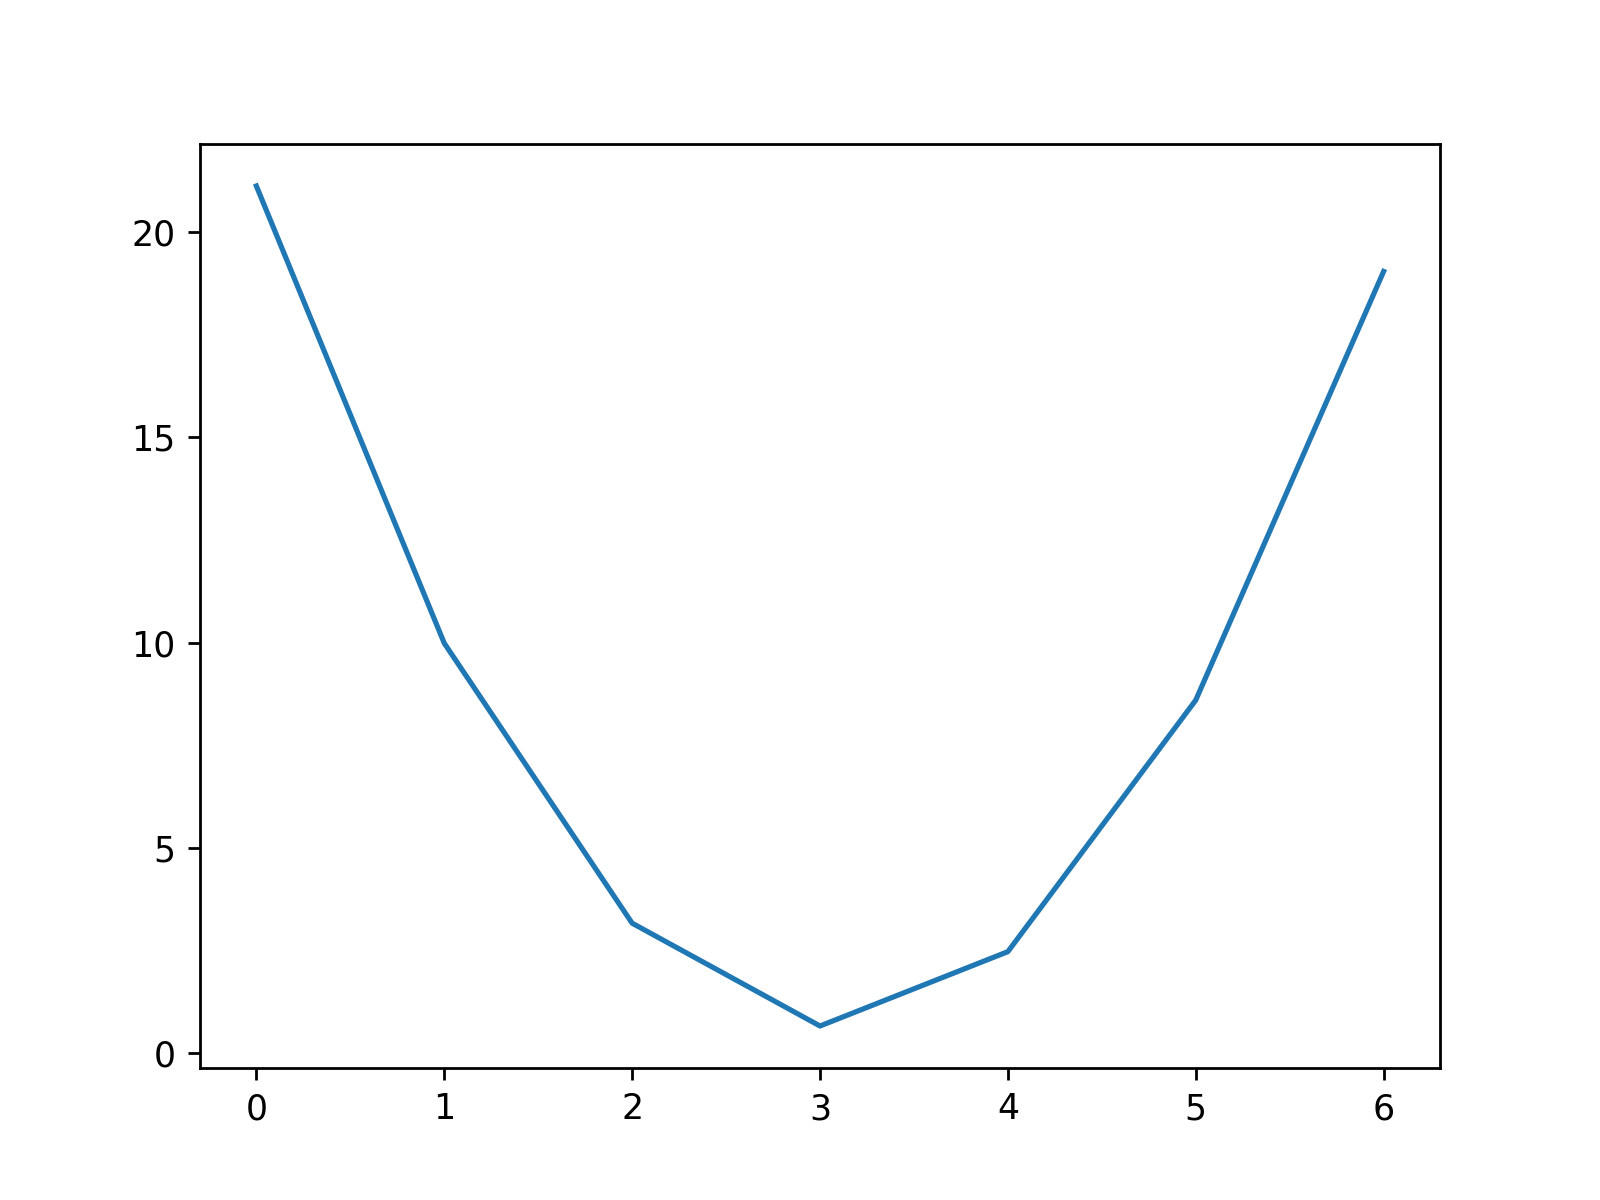

In [10]:
def cost(a,x, y):
    yn=a*x
    return np.sum((y-yn)**2)
pentes=[0,1, 2, 3, 4, 5, 6]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(pentes, [cost(p,x,y ) for p in pentes])
plt.show()

Nous devons maintenant miniser $S(a)$, c'est-à-dire trouver la pente $a$ qui donne la plut petite erreur. 
Écrire une fonction qui, à partir d'une list de pentes à essayer et des points $x$ et $y$ , trouve la meilleures pente dans la liste, c'est à dire celle qui donne le plus petit coût.

In [11]:
def best_slope(a_list,x,y):
    return min(a_list, key=lambda z: cost(z,x,y))
print(best_slope([0.,1.0,2.0,3.0,4.0],x,y),best_slope([2.8,3.0,3.2, 3.3, 3.4],x,y))

3.0 3.0


Nous allons effectuer une régression linéaire simplifiée come suit:
- Partir d'un interval donné. 
- Prendre $N$ valeur de pente equidistantes dans cette interval.
- Trouver la meilleure 
- Recommencer en prenant comme nouvel interval celui défini par les 2 valeurs de pente autour de la meilleure 
L'algorithme s'arretera lorsque on sait que la meilleure pente se trouve dans un interval plus petit qu'une certaine tolérance.

Est-t-il une bonne idée de prendre $N$ grand? 

In [12]:
def Da(rng, N):
    return abs(rng[1]-rng[0])/N
def simple_lreg(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while Da(rng,N) > thr:
        alist=np.linspace(rng[0],rng[1],N)
        ba=best_slope(alist,x,y)
        count+=len(alist)
        rng=[ba-Da(rng,N),ba+Da(rng,N)]
    print("after trying ",count," slopes")
    return ba, count

In [13]:
simple_lreg(x,y,0.0001,[1.,5.],7)

after trying  49  slopes


(3.0801706771838262, 49)

In [14]:
simple_lreg(x,y,0.0001,[1.,5.],20)

after trying  80  slopes


(3.0803157894736839, 80)

Il y a des méthodes plus formelles pour résoudre ce problème.
Nous avons des points $x_i$ et des mesures $y_i$, et l'on suppose que l'on peut approximativement représenter leur relation avec une fonction affine (sans constante): 
\begin{align}
y_i&\approx cte \times x_i \\
\end{align}
Avec $a$, on obtient des prédictions $\hat{y}_i$
\begin{align}
\hat{y}_i&=a x_i\\
\end{align}
avec une erreur $\epsilon_i$ dont veut miniser la somme des carrés $S(a)$:
\begin{align}
\epsilon_i&=\hat{y}_i-y_i\\
S(a)&=\sum_i \epsilon_i^2
\end{align}
On doit trouver le minimum de la fonction $S(a)$. La fonction $S(a)$ est minimal lorsque sa dérivé par rapport à $a$ s'annule (voir le tracé de $S(a)$ plus haut)
\begin{align}
\frac{dS(a)}{da}&=\frac{d\sum_i \epsilon_i^2}{da}=0
\end{align}
En dérivant l'expression ci-dessus, on obtient:
\begin{align}
\frac{d\sum_i (y_i-a x_i)^2}{da}&=\sum_i x_i (y_i-a x_i)=0 \\
\sum_i x_i y_i&=a \sum_i x_i^2 \\
a&=\frac{\sum_i x_i y_i}{\sum_i x_i^2}
\end{align}
Vérifier que l'on trouve un nombre similaire avec cette formule.

In [15]:
sum(x*y)/sum(x**2)

3.0803473299700164

# variable multi-dimensionelle

Supposons maintenant que nous avons plusieurs 2 variable endogènes (explicatives) $x_{1,i}, x_{2,i}$ et toujours une variable à trouver $y_i$. On suppose toujours que l'on peut approximativement représenter leur relation linéairement, enfaisant la somme des 2 fonctions affines : 
\begin{align}
y_i&\approx cte_1 x_{1,i}+cte_2 x_{2,i} \\
\end{align}
Avec $a_1, a_2$, on obtient des prédictions $\hat{y}_i$
\begin{align}
\hat{y}_i&=a_1 x_{1,i}+a_2 x_{2,i}\\
\end{align}
avec une erreur $\epsilon_i$ dont veut miniser la somme des carrés $S(a_1, a_2)$:
\begin{align}
\epsilon_i&=\hat{y}_i-y_i\\
S(a_1, a_2)&=\sum_i \epsilon_i^2
\end{align}
On doit trouver le minimum de la fonction $S(a_1, a_1)$. Cette fois, c'est une fonction de 2 variables. On doit donc trouver le minimum sur une surface.

<IPython.core.display.Javascript object>


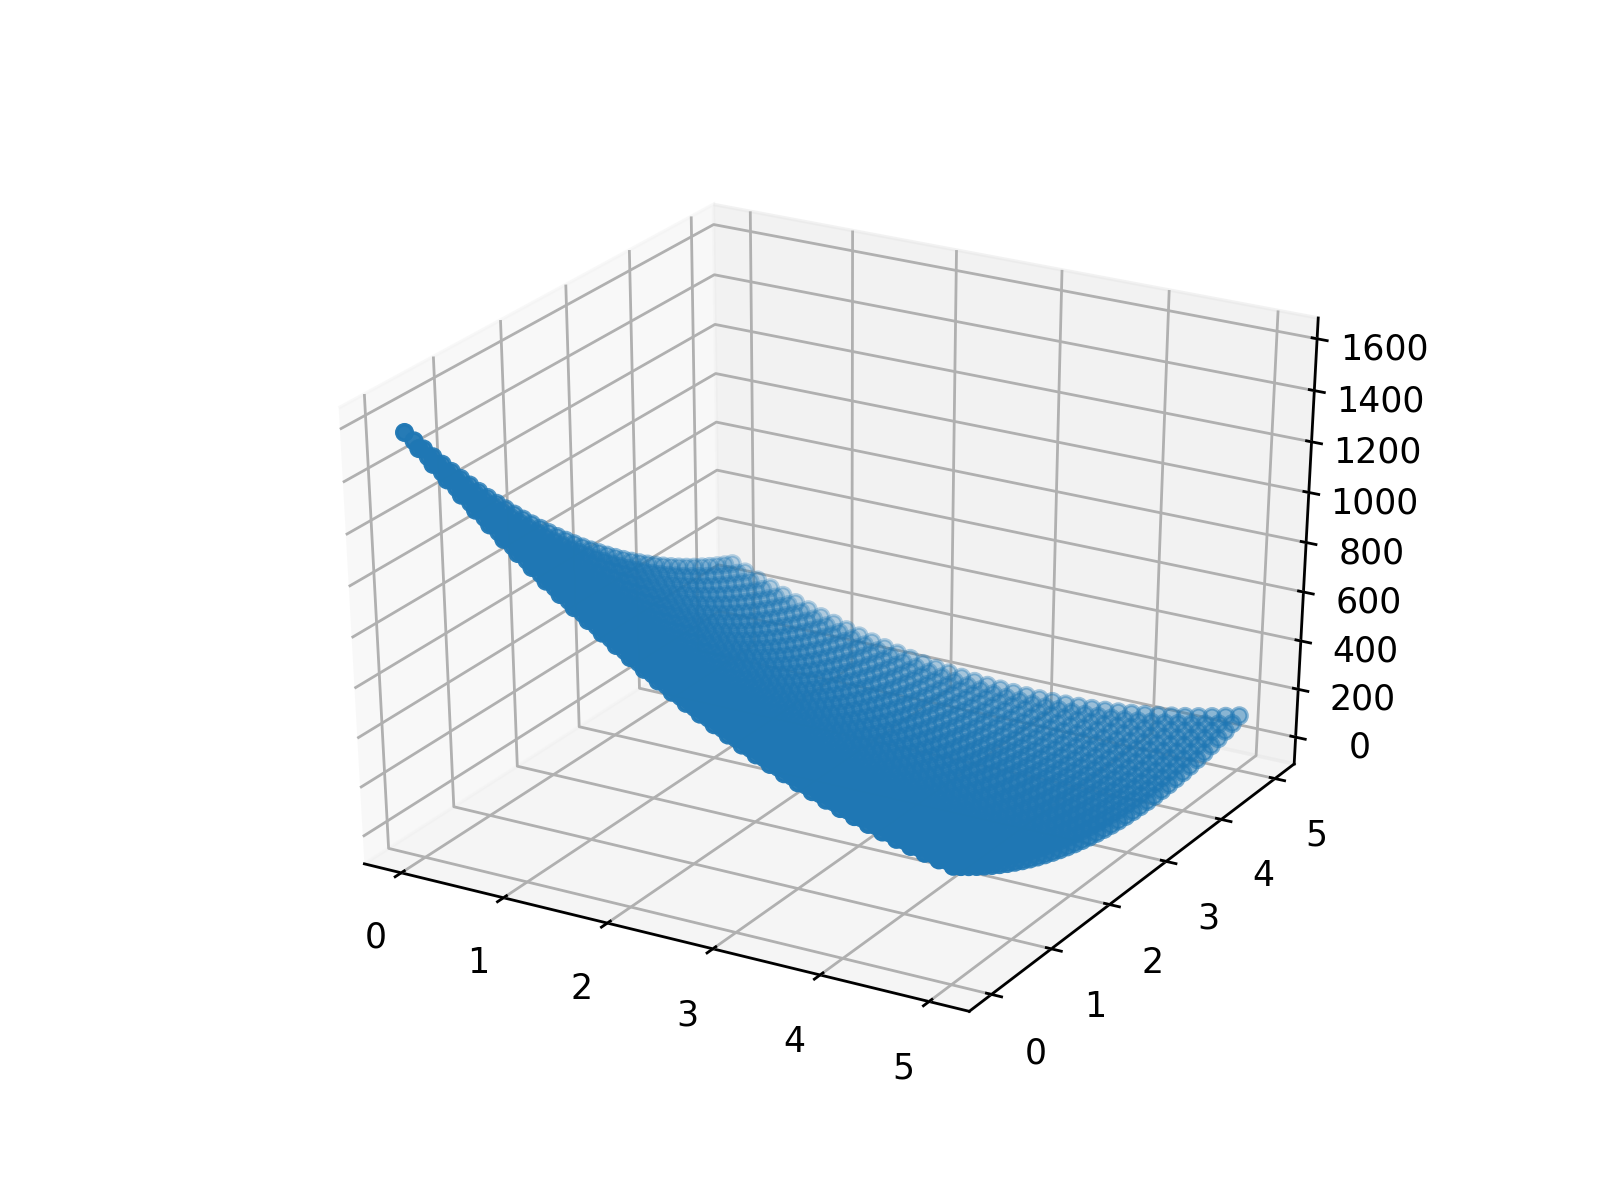

In [16]:
Nx=100
a=np.array([rand_in(1,5), rand_in(1,5)])
x=np.array([np.random.random(Nx),np.random.random(Nx)])
y=a[0]*x[0,:]+a[1]*x[1,:]+np.array([np.random.normal(scale=0.1) for i in range(Nx)])
def cost2d(a,x, y):
    yn=a[0]*x[0,:]+a[1]*x[1,:]
    return np.sum((y-yn)**2)
pentes=np.linspace(0,5,40)
data=np.array([[p1,p2,cost2d([p1,p2],x,y)] for p1,p2 in product(pentes, pentes)] )
fig=plt.figure()
ax=plt.subplot(111,projection='3d')
ax.scatter(data[:,0],data[:,1],data[:,2])
plt.show()

Ce problème peut également être résolu formellement.
La fonction $S(a_1, a_2)$ est minimal lorsque sa dérivé par rapport à $a_1, a_2$ s'annule:
\begin{align}
\frac{dS(a_1)}{da}&=\frac{dS(a_2)}{da}=0
\end{align}
En dérivant les expressions ci-dessus, on obtient:
\begin{align}
\sum_i x_{1,i} (y_i-a_1 x_{1,i}-a_2 x_{2,i})=0 \\
\sum_i x_{2,i} (y_i-a_1 x_{1,i}-a_2 x_{2,i})=0 \\
\end{align}
Ce qui nous donne un système de 2 équations à 2 inconnues: 
\begin{align}
\sum_i x_{1,i}y_i=a_1 \sum_i x^2_{1,i}- a_2 \sum_i x_{1,i} x_{2,i} \\
\sum_i x_{2,i} y_i= a_1 \sum_i x_{2,i} x_{1,i}- a_2 \sum_i x^2_{2,i} \\
\end{align}
Il est alors plus pratique d'écrire le problème sous forme sous forme matricielle:
\begin{align}
\hat{Y}&= \hat{A} X\\
\end{align}
la minimisation des distances au carré revient à résoudre:
\begin{align}
0&=X^{T} (Y-\hat{A} X) \\
\hat{A} &= (X^{T} X)^{-1} X^{T}Y 
\end{align}

In [17]:
X=x.T
Y=y
Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )
print(Afit, a)

[ 3.40583925  4.5296082 ] [ 3.4083117   4.53850934]


Ce que l'on a fait pour 1 puis 2 variables endogènes peut être généralisé à $N_{var}$. 
La dérivation est la même, le systême d'équation et les matrices corespnodant sont simplement plus grands. 
\begin{align}
y_i&\approx \sum_j cte_j \times x_{j,i} \\
\end{align}
Avec $\hat{a}_j$, on obtient des prédictions $\hat{y}_i$
\begin{align}
\hat{y}_i&=\sum_j \hat{a}_j x_{j,i}\\
\end{align}


In [35]:
Nvar=7
Np=100
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+np.array([np.random.normal(scale=1.0) for i in range(Np)])
Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

0.0585824204708


<IPython.core.display.Javascript object>


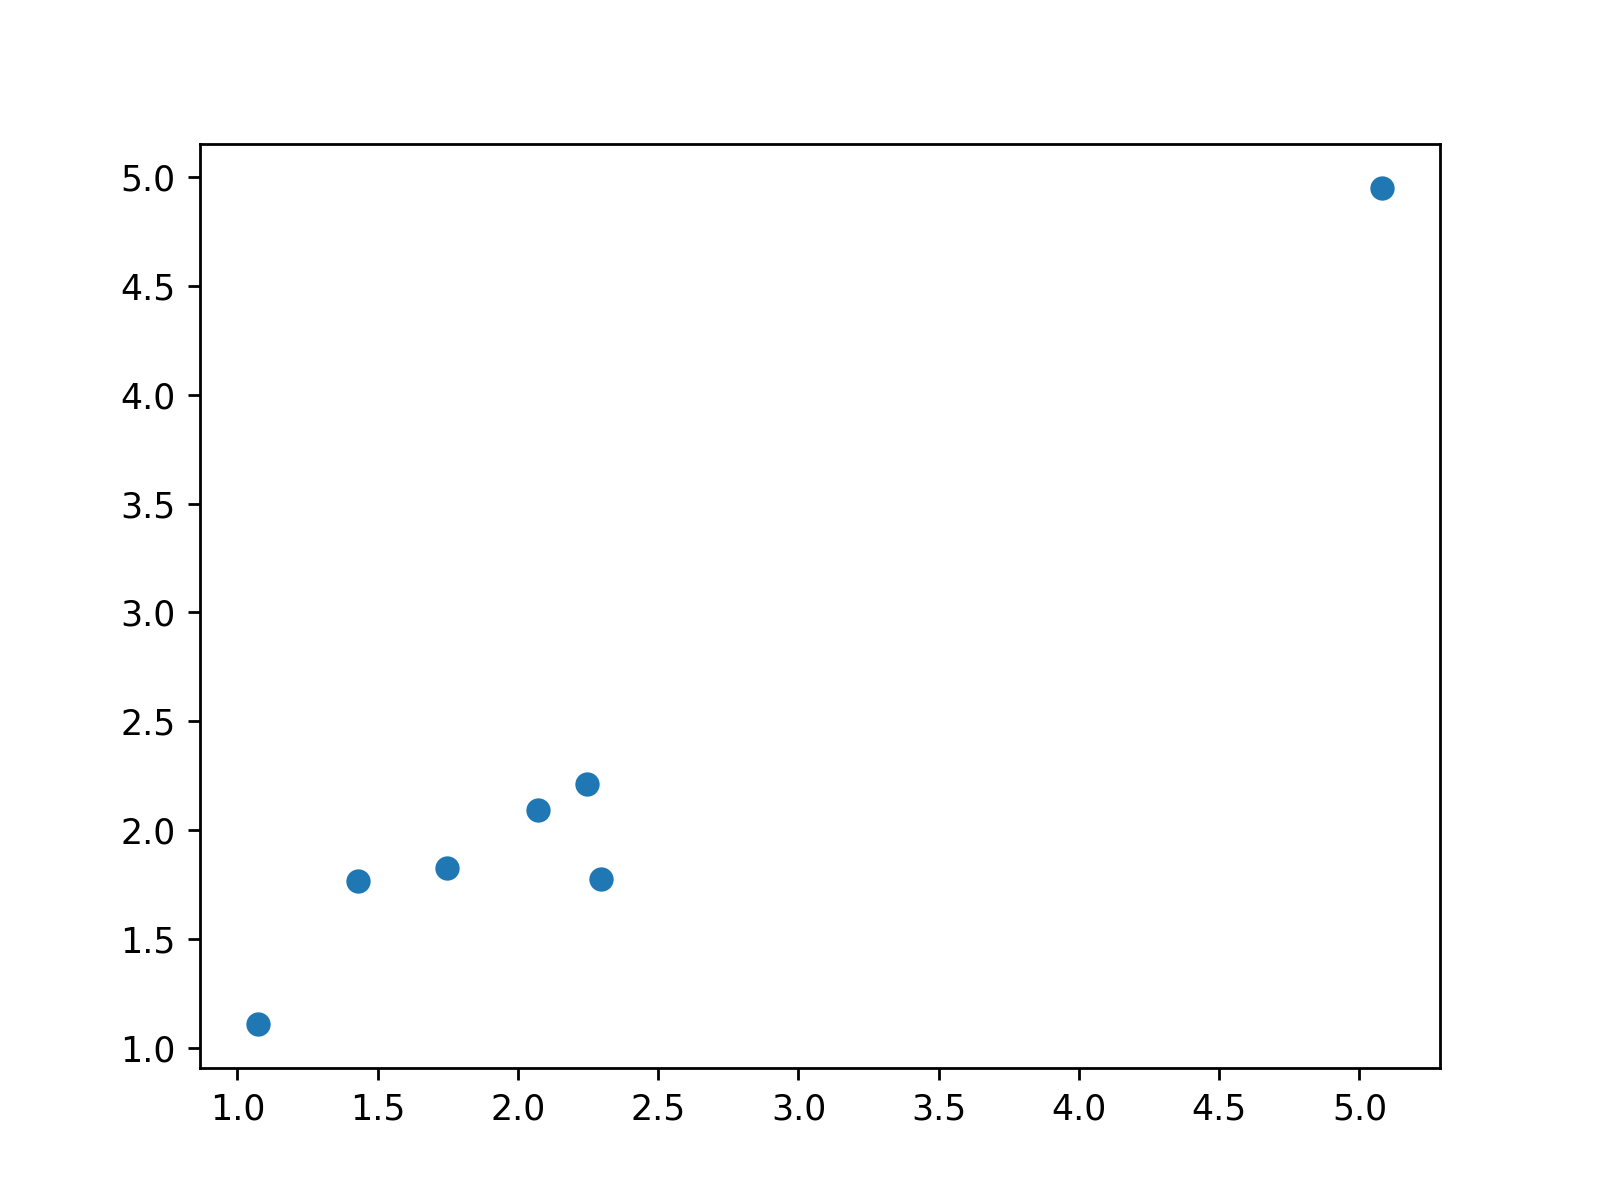

In [47]:
print(np.sum((A-Afit)**2)/Nvar)
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Afit,A)
plt.show()

# Entrainement

Le nombre d'élements $x_i$ accroit la qualité de la régression linaire.

In [48]:
Nvar=7
A=np.array([rand_in(1,5) for i in range(Nvar)])

<IPython.core.display.Javascript object>


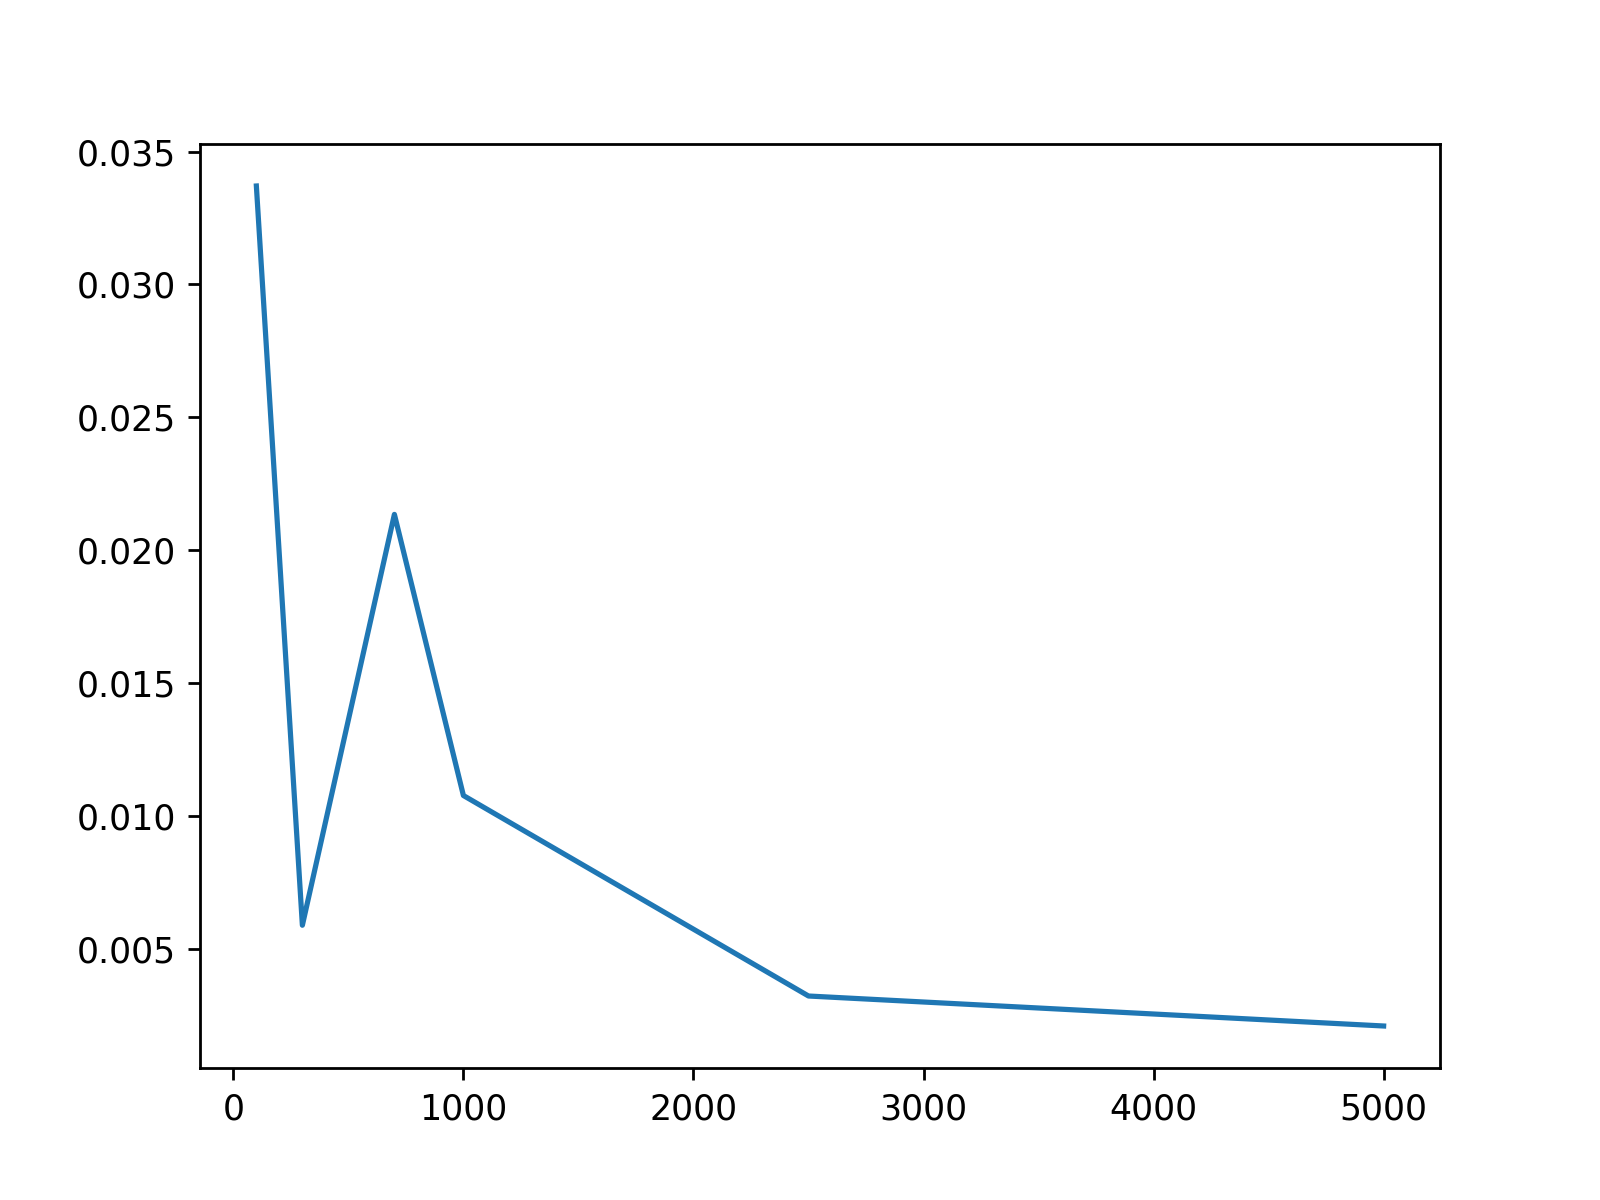

In [52]:
fig=plt.figure()
ax=plt.subplot(111)
Nps=[ 100,300,700, 1000, 2500, 5000]
errors=[]
for Np in Nps:
    X=np.array([np.random.random(Np) for i in range(Nvar)]).T
    Y=np.dot(X,A)+np.array([np.random.normal(scale=1.0) for i in range(Np)])
    Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )
    errors.append(np.sum((A-Afit)**2)/Nvar)
ax.plot(Nps,errors)
plt.show()

# Entrainement et test

In [24]:
Np=1000
Nvar=7
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+np.array([np.random.normal(loc=np.rint(2*(float(i)-Np/2)/Np),scale=1.0) for i in range(Np)])

In [28]:
Ntr=800
Xtr=X[:Ntr,:]
Ytr=Y[:Ntr]
Xte=X[Ntr:,:]
Yte=Y[Ntr:]
Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

<IPython.core.display.Javascript object>


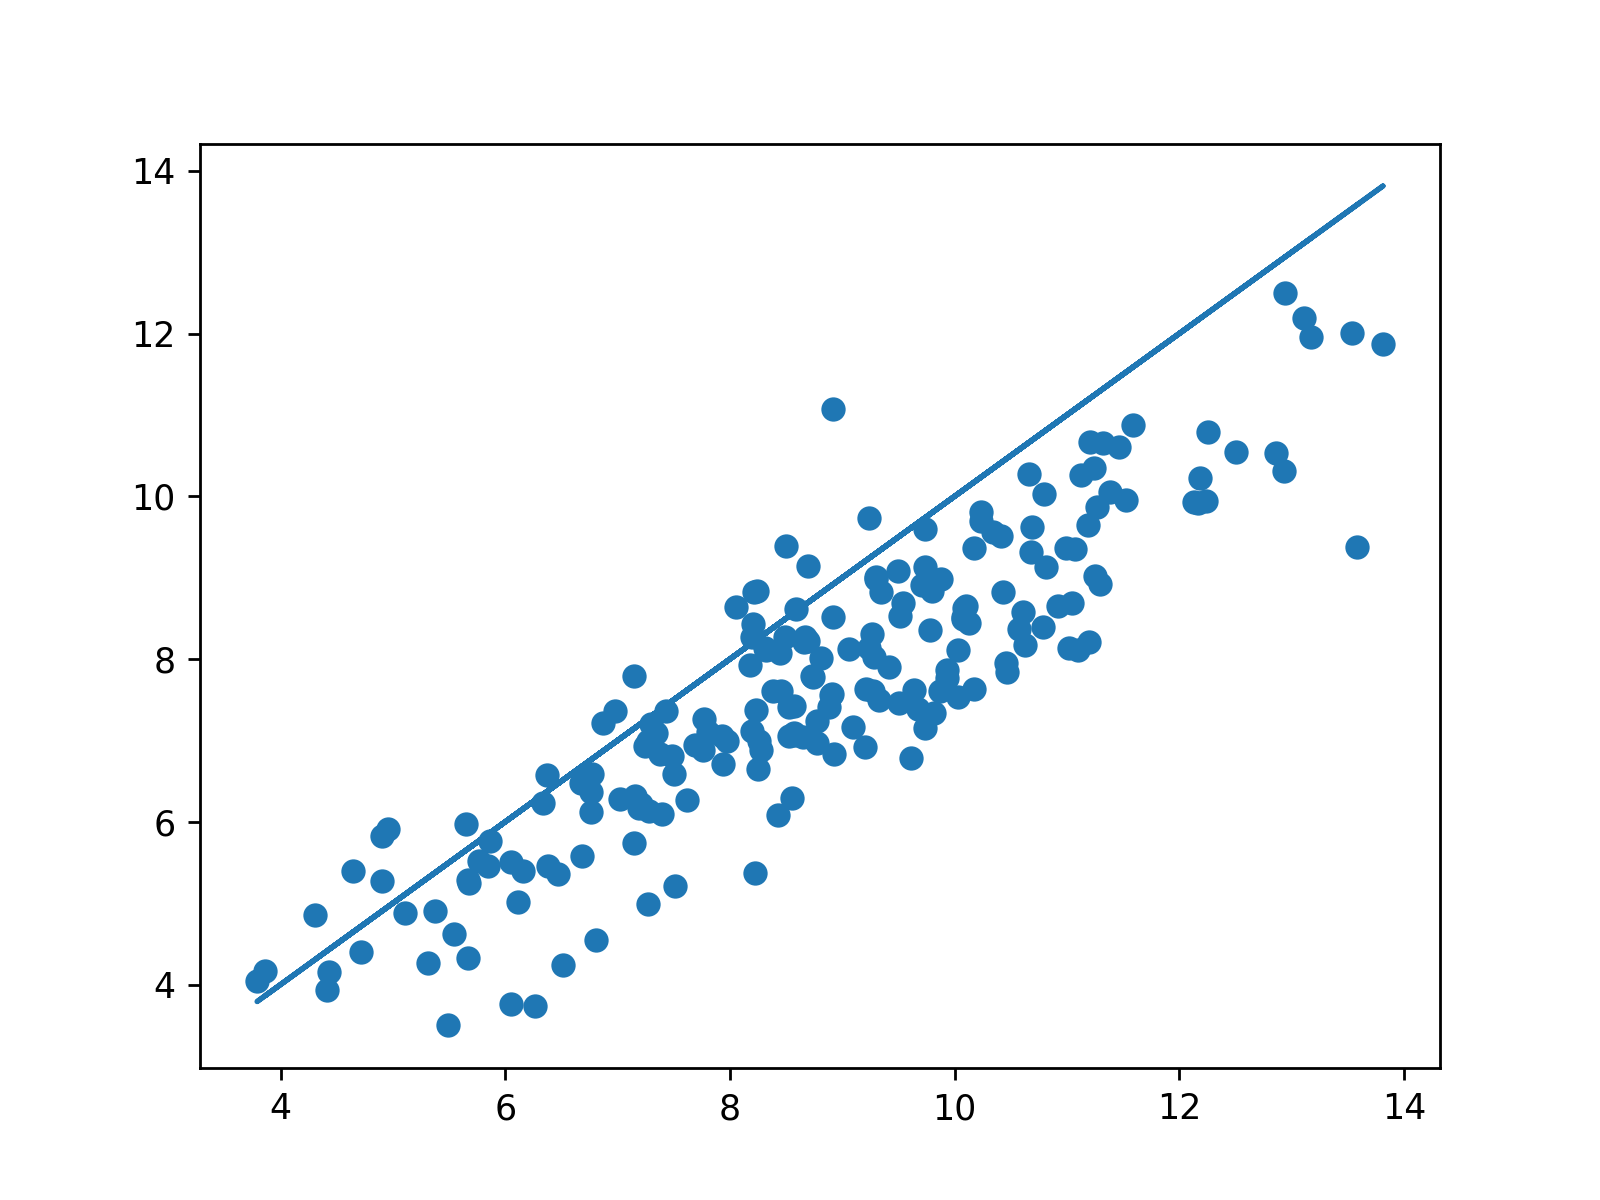

1.44526729293


In [29]:
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

In [40]:
indices = np.random.permutation(Np)
training_idx, test_idx = indices[:Ntr], indices[Ntr:]
Xtr, Xte = X[training_idx,:], X[test_idx,:]
Ytr, Yte = Y[training_idx], Y[test_idx]
Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

<IPython.core.display.Javascript object>


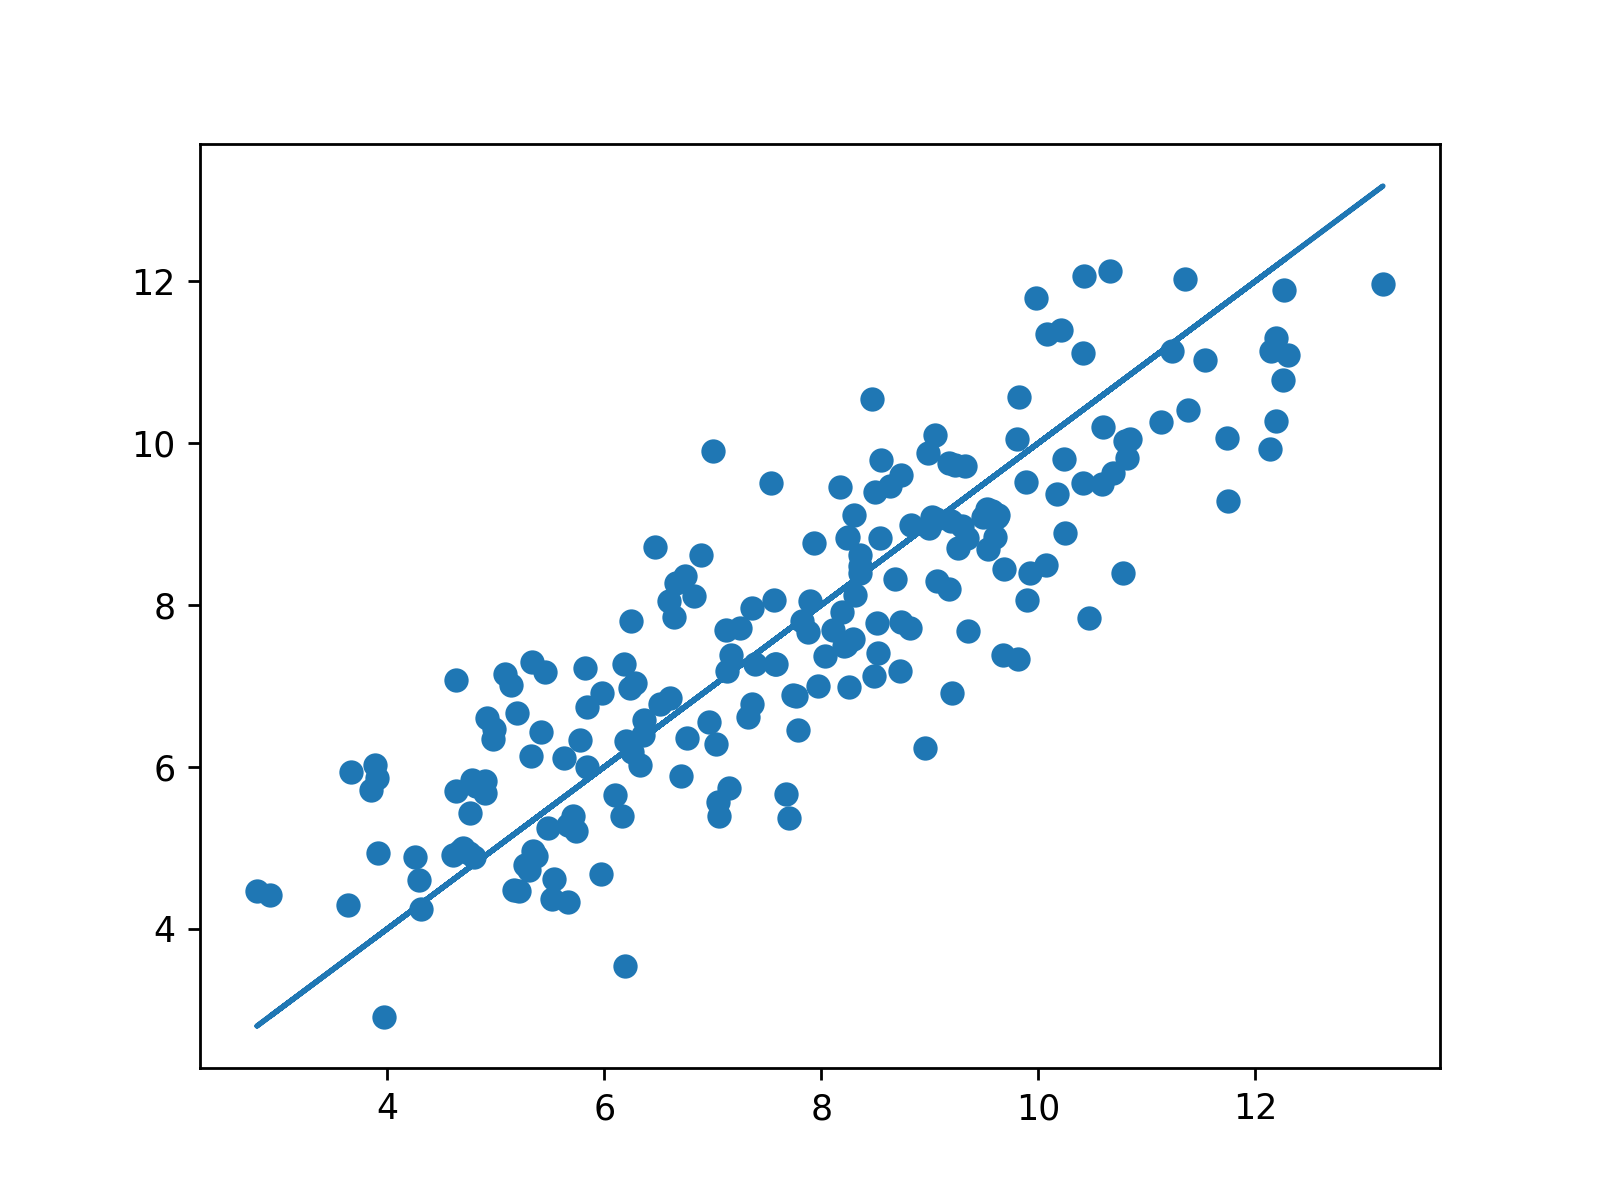

1.16312745812


In [41]:
fig=plt.figure()
ax=plt.subplot(111)
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

<IPython.core.display.Javascript object>


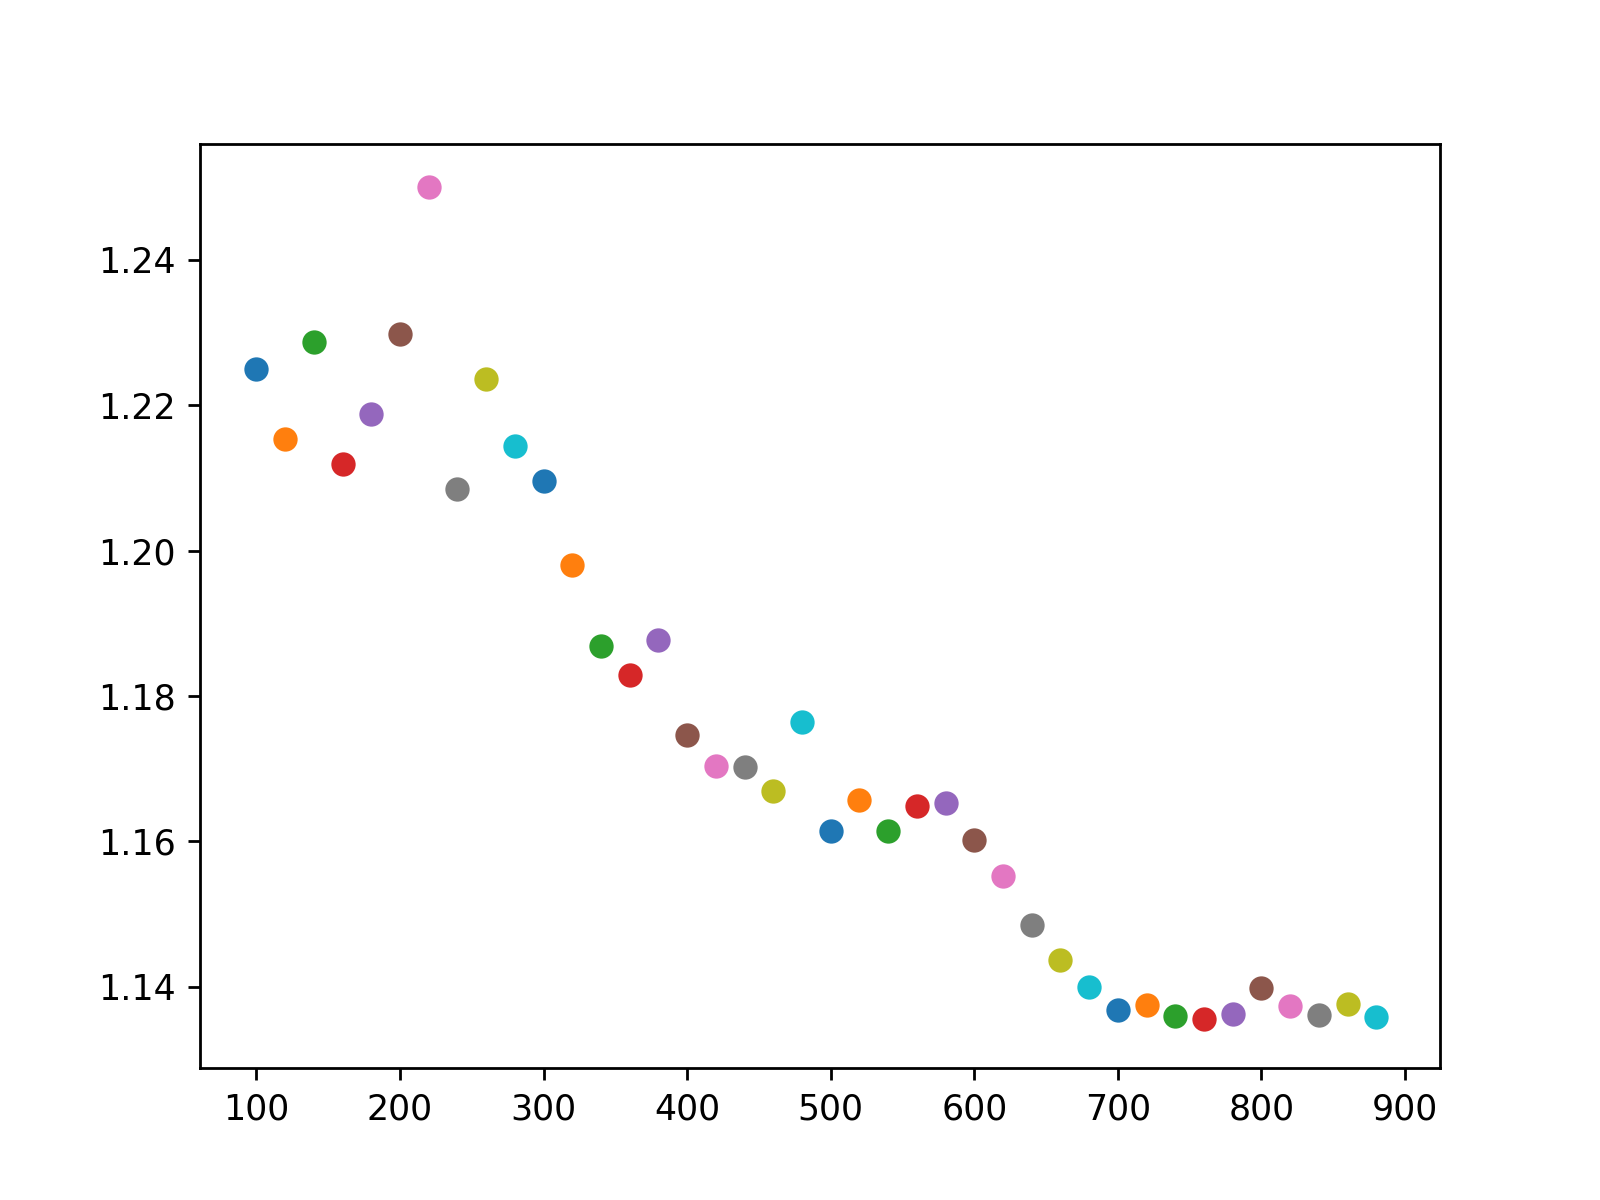

In [21]:
fig=plt.figure()
ax=plt.subplot(111)
Ntrs=np.arange(100, 900, 20)
for Ntr in Ntrs:
    Xtr=X[:Ntr,:]
    Ytr=Y[:Ntr]
    Xte=X[-100:,:]
    Yte=Y[-100:]
    Afit=np.dot( np.linalg.inv(np.dot(Xtr.T,Xtr)) , np.dot(Xtr.T,Ytr) )
    #ax.scatter(Ntr,np.sum((A-Afit)**2)/Nvar )
    ax.scatter(Ntr,np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte))
plt.show()